## MLP

In [1]:
!pip install optuna plotly

In [52]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import optuna
import plotly
import math

### Preprocess data

In [53]:
drop_columns = ['inflow', 'date']

# inflow_path = 'csv/inflow.csv'
# inflow_data = pd.read_csv(inflow_path)
# train_data['inflow'] = inflow_data['Inflow']

train_path = 'csv/train.csv'
train_data = pd.read_csv(train_path)
train_data = train_data[train_data['inflow'] <= 8000]
# train_data = train_data.dropna()

X_train = train_data.drop(columns=drop_columns)
y_train = train_data['inflow']

val_path = 'csv/val.csv'
val_data = pd.read_csv(val_path)
val_data = val_data[val_data['inflow']<=8000]
# val_data = val_data.dropna()

X_val = val_data.drop(columns=drop_columns)
y_val = val_data['inflow']

test_path = 'csv/test.csv'
test_data = pd.read_csv(test_path)
test_data = test_data[test_data['inflow']<=8000]
# test_data = test_data.dropna()

X_test = test_data.drop(columns=drop_columns)
y_test = test_data['inflow']

In [54]:
def check_nan(data):
    return data.isna().any().any()

if check_nan(train_data):
    print("NaN values are present in the training data.")
else:
    print("No NaN values in the training data.")


def print_nan_rows(data):
    """
    Function to print all rows containing NaN values in the DataFrame.

    Parameters:
    data (pd.DataFrame): The DataFrame to check for NaN values.

    Returns:
    None
    """
    nan_rows = data[data.isna().any(axis=1)]
    
    if not nan_rows.empty:
        print("Rows containing NaN values:")
        print(nan_rows)
    else:
        print("No rows contain NaN values.")

print_nan_rows(train_data)


No NaN values in the training data.
No rows contain NaN values.


In [55]:
scaler = StandardScaler()
# scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [56]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

In [40]:
# min_values = np.min(X_train_scaled, axis=0)
# max_values = np.max(X_train_scaled, axis=0)

# print("Min values for each feature in X_train_scaled:", min_values)
# print("Max values for each feature in X_train_scaled:", max_values)

min_y = np.min(y_train)
max_y = np.max(y_train)
print(f"min and max in y are: {min_y} and {max_y}")

min and max in y are: 0.0 and 7407.407407407414


### Model

In [57]:
from sklearn.neural_network import MLPRegressor

class MLPModel:
    def __init__(self, hidden_size1, hidden_size2, activation, solver, max_iter):
        # Initialize the MLPRegressor model with 2 hidden layers
        self.model = MLPRegressor(hidden_layer_sizes=(hidden_size1, hidden_size2),
                                  activation=activation,
                                  solver=solver,
                                  max_iter=max_iter,
                                  learning_rate='adaptive',
                                  learning_rate_init=0.001)

    def train(self, X_train, y_train):
        # Train the model using the training data
        self.model.fit(X_train, y_train)

    def predict(self, X_new):
        # Predict inflow for new data
        return self.model.predict(X_new)

### Hyperparameter tuning
- used optuna


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_train = y_train.ravel()
y_test = y_test.ravel()

def objective(trial):
    # Hyperparameters to be tuned
    hidden_size1 = trial.suggest_int('hidden_size1', 128, 1024)
    hidden_size2 = trial.suggest_int('hidden_size2', 128, 1024)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    max_iter = trial.suggest_int('max_iter', 200, 1000)

    # Create and train the model
    model = MLPModel(hidden_size1, hidden_size2, activation, solver, max_iter)
    model.train(X_train_scaled, y_train_scaled)  # Training on scaled y
    
    # Predict on validation data
    y_pred_scaled = model.predict(X_val_scaled).reshape(-1, 1)  # Ensure 2D for inverse scaling
    
    # Inverse transform to get original scale
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled).ravel()  # Flatten again after inverse scaling
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_val, y_pred_original)

    return mse

In [46]:
study = optuna.create_study(direction='minimize') 
study.optimize(objective, n_trials=15)

print('Best trial:')
print(study.best_trial.params)

[I 2024-10-17 17:28:46,062] A new study created in memory with name: no-name-52504f2d-4cb9-40e3-b7eb-d667ea5b284e
[I 2024-10-17 17:30:41,665] Trial 0 finished with value: 754518.8253393541 and parameters: {'hidden_size1': 978, 'hidden_size2': 858, 'activation': 'relu', 'solver': 'sgd', 'max_iter': 974}. Best is trial 0 with value: 754518.8253393541.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (667) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2024-10-17 17:31:15,456] Trial 1 finished with value: 728045.8737686682 and parameters: {'hidden_size1': 473, 'hidden_size2': 616, 'activation': 'relu', 'solver': 'sgd', 'max_iter': 667}. Best is trial 1 with value: 728045.8737686682.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Op

Best trial:
{'hidden_size1': 302, 'hidden_size2': 863, 'activation': 'tanh', 'solver': 'adam', 'max_iter': 881}


### Evaluate model

In [63]:
params = study.best_trial.params
model = MLPModel(
    hidden_size1=params['hidden_size1'],
    hidden_size2=params['hidden_size2'],
    activation=params['activation'],
    solver=params['solver'],
    max_iter=params['max_iter']
)

# Train the model
model.train(X_train_scaled, y_train_scaled)

# Predict on test data
y_pred_scaled = model.predict(X_test_scaled)
y_pred_scaled = y_pred_scaled.reshape(-1, 1)

# Inverse transform the scaled predictions
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
y_pred_original = np.clip(y_pred_original, 0, None)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_original)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_original)
r2 = r2_score(y_test, y_pred_original)

# Print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 27946.4990433906
Root Mean Squared Error (RMSE): 167.1720641835549
Mean Absolute Error (MAE): 74.20661154790379


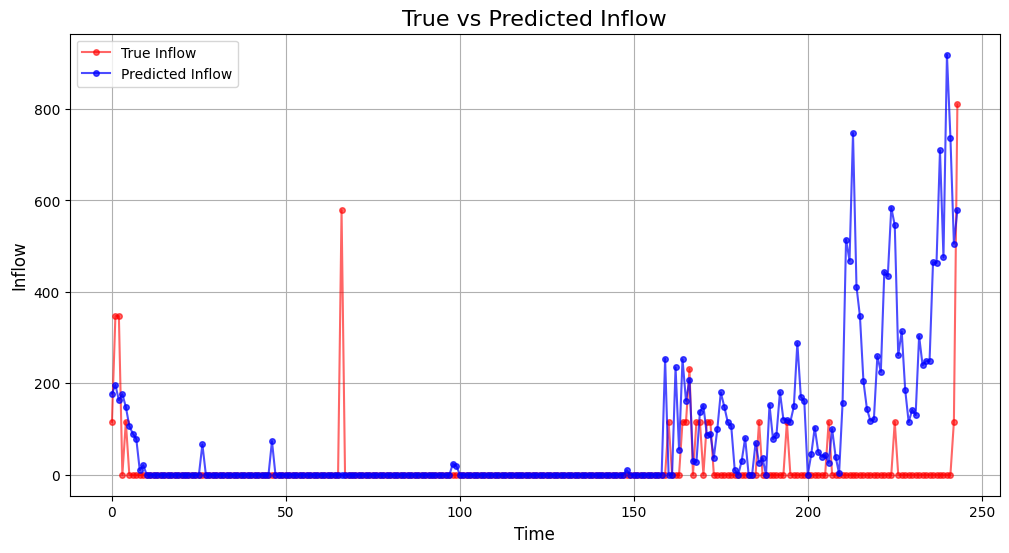

In [64]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

# Plot true inflow (red line)
plt.plot(np.arange(len(y_test)), y_test, marker='o', linestyle='-', color='red', alpha=0.6, markersize=4, label='True Inflow')

# Plot predicted inflow (blue line)
plt.plot(np.arange(len(y_pred_original)), y_pred_original, marker='o', linestyle='-', color='blue', alpha=0.7, markersize=4, label='Predicted Inflow')

# Add title and labels
plt.title('True vs Predicted Inflow', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Inflow', fontsize=12)

# Add legend to distinguish lines
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
